# Summary

**This notebook takes predictions formatted the same way as submissions from previous competitions to simulate n brackets.**

- The predictions should have the columns `ID` and `Pred`. Where ID has the following format year_team1_team2 and the prediction is the the predicted probability of team1 winning against team2. 

- Setting `n_brackets=1` and `sim=False` will give you a single full-chalk bracket for each tournament.

Update: Found an inefficiency in the rng of my code after looking at this [simulation notebook](https://www.kaggle.com/code/goodspellr/seed-benchmark-submission) for the Seed-Benchmark by Good Spellr. Updated version should be much faster. Further performance improvements after suggestion by Ryan Armstrong to [precompute the random-values](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/discussion/482696#2690435).

In [167]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm

# Load and filter data
round_slots = pd.read_csv('./march-machine-learning-mania-2025/MNCAATourneySlots.csv')
round_slots = round_slots[round_slots['Season'] == 2024]
round_slots = round_slots[round_slots['Slot'].str.contains('R')] # Filter out First Four

seeds_m = pd.read_csv("march-machine-learning-mania-2025/MNCAATourneySeeds.csv")

# CHANGE TO 2025 FOR FINAL SIMULATION
seeds_m = seeds_m[seeds_m['Season'] == 2024]
# seeds_m = seeds_m[seeds_m['Season'] == 2024].copy()
# seeds_m['Season'] = 2025

seeds_w = pd.read_csv("march-machine-learning-mania-2025/WNCAATourneySeeds.csv")

# CHANGE TO 2025 FOR FINAL SIMULATION
seeds_w = seeds_w[seeds_w['Season'] == 2024]
# seeds_w = seeds_w[seeds_w['Season'] == 2024].copy()
# seeds_w['Season'] = 2025

preds = pd.read_csv('./submission.csv') 
preds['ID'] = preds['ID'].str.split('_')

# Have to fix X16, Y10, Y16, Z10 (change for 2025 seeds when we get them)

# X16 = Wagner = 1447
seeds_m = pd.concat([seeds_m, pd.DataFrame([{'Season': 2024, 'Seed': 'X16', 'TeamID': 1447}])], ignore_index=True)
# Y10 = Colorado St = 1161
seeds_m = pd.concat([seeds_m, pd.DataFrame([{'Season': 2024, 'Seed': 'Y10', 'TeamID': 1161}])], ignore_index=True)
# Y16 = Grambling = 1212
seeds_m = pd.concat([seeds_m, pd.DataFrame([{'Season': 2024, 'Seed': 'Y16', 'TeamID': 1212}])], ignore_index=True)
# Z10 = Colorado = 1160
seeds_m = pd.concat([seeds_m, pd.DataFrame([{'Season': 2024, 'Seed': 'Z10', 'TeamID': 1160}])], ignore_index=True)

In [168]:
def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index('Seed')['TeamID'].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}
    
    for teams, proba in zip(preds['ID'], preds['Pred']):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, random_values, sim=True):
    '''
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities.
    - random_values (array-like): Array with precomputed random-values.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team IDs for each match.
    - list: List with corresponding slot names for each match.
    '''
    winners = []
    slots = []

    for slot, strong, weak, random_val in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed, random_values):
        team1, team2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
        proba = probas[str(team1)][str(team2)]
            
        if sim:
            # Randomly determine the winner based on the probability
            winner = team1 if random_val < proba else team2
        else:
            # Determine the winner based on the higher probability
            winner = [team1, team2][np.argmax([proba, 1-proba])]
            
        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    '''
    Runs a simulation of bracket tournaments.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - preds (pd.DataFrame): DataFrame containing prediction information for each match-up.
    - round_slots (pd.DataFrame): DataFrame containing information about the tournament rounds.
    - sim (boolean): Simulates matches if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    '''
    # Get relevant data for the simulation
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    # Lists to store simulation results
    results = []
    bracket = []
    slots = []
    
    # Precompute random-values
    random_values = np.random.random(size=(brackets, len(round_slots)))

    # Iterate through the specified number of brackets
    for b in tqdm(range(1, brackets+1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, random_values[b-1], sim)
        
        # Update results
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final DataFrame
    result_df = pd.DataFrame({'Bracket': bracket, 'Slot': slots, 'Team': results})

    return result_df

n_brackets = 1

# The key error is from the first four not having their results in the seeds csv, have to manually change/add those to make this work
result_m=run_simulation(brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=True)
result_m['Tournament'] = 'M'
# result_w=run_simulation(brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=True)
# result_w['Tournament'] = 'W'
submission = result_m
# submission = pd.concat([result_m, result_w])

submission.reset_index(inplace=True, drop=True)
submission.index.names = ['RowId']

100%|██████████| 1/1 [00:00<00:00, 5289.16it/s]


In [169]:
submission.to_csv('bracket_simulations.csv')
submission

,Bracket,Slot,Team,Tournament
RowId,,,,
0,1,R1W1,W01,M
1,1,R1W2,W02,M
2,1,R1W3,W03,M
3,1,R1W4,W04,M
4,1,R1W5,W05,M
...,...,...,...,...
58,1,R4Y1,Y01,M
59,1,R4Z1,Z03,M
60,1,R5WX,X02,M


W01
W02
W03
W04
W05
W06
W07
W09
X01
X02
X14
X04
X05
X11
X10
X09
Y01
Y02
Y03
Y04
Y05
Y06
Y07
Y08
Z01
Z02
Z03
Z04
Z12
Z11
Z07
Z09
W01
W02
W03
W04
X01
X02
X11
X05
Y01
Y07
Y03
Y04
Z09
Z07
Z03
Z04
W01
W02
X01
X02
Y01
Y07
Z09
Z03
W02
X02
Y01
Z03
X02
Y01
X02


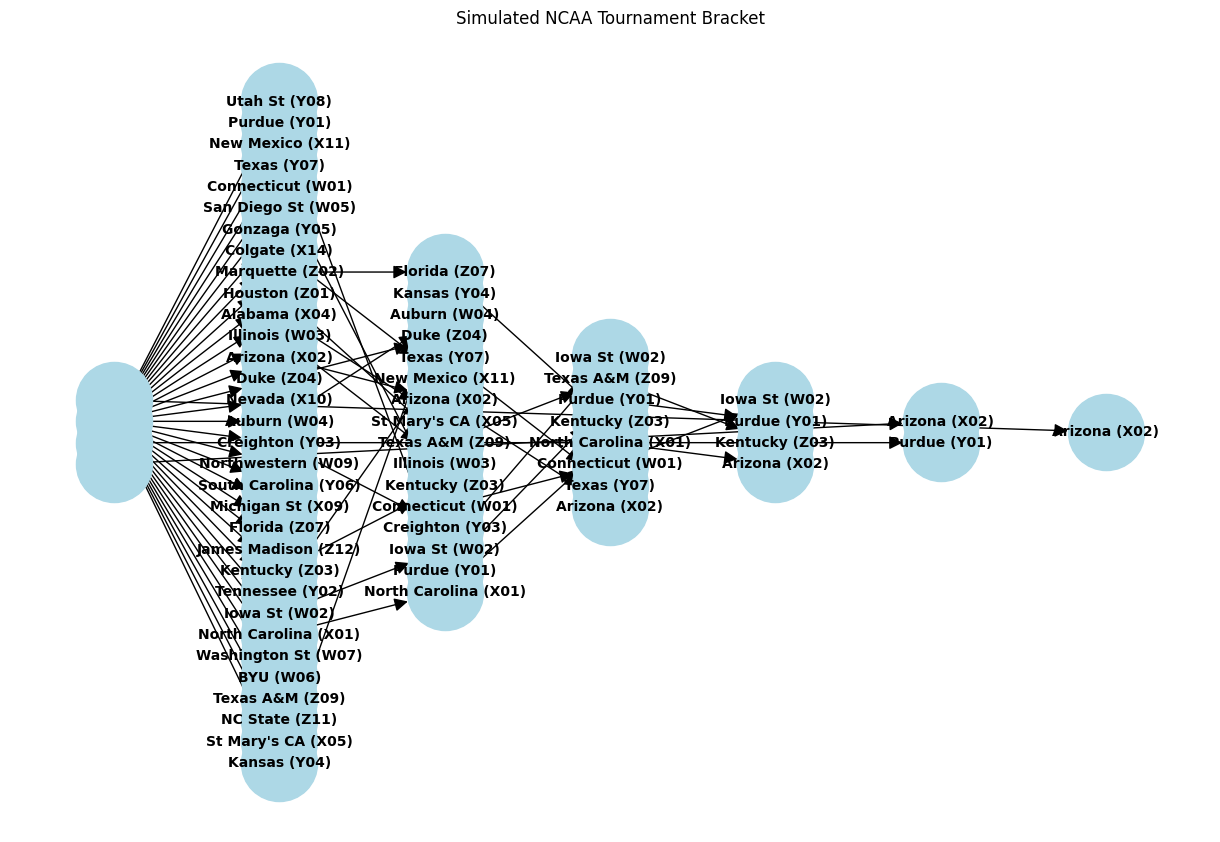

In [170]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the necessary data
teams = pd.read_csv("march-machine-learning-mania-2025/MTeams.csv")

# Merge the seeds_m dataframe with the teams dataframe to get team names
seeds_m = seeds_m.merge(teams[['TeamID', 'TeamName']], on='TeamID')

# Create a dictionary to map team IDs to team names and seeds
team_info = {}
for _, row in seeds_m.iterrows():
    team_info[row['Seed']] = {
        'TeamName': row['TeamName'],
        'TeamID': row['TeamID']
    }

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in submission.iterrows():
    slot = row['Slot']
    seed = row['Team']
    print(seed)
    team_name = team_info[seed]['TeamName']
    G.add_node(slot, label=f"{team_name} ({seed})", subset=int(slot[1]) if slot != 'Start' else 0)
    if slot.startswith('R1'):
        G.add_edge('Start', slot)
    else:
        prev_round = f"R{int(slot[1]) - 1}{slot[2:]}"
        G.add_edge(prev_round, slot)

# Ensure all nodes have the 'subset' attribute
for node in G.nodes:
    if 'subset' not in G.nodes[node]:
        G.nodes[node]['subset'] = 0

# Draw the graph
pos = nx.multipartite_layout(G, subset_key='subset')
labels = nx.get_node_attributes(G, 'label')
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title("Simulated NCAA Tournament Bracket")
plt.show()